<font size="6"> **Model Building** </font>

Apply advanced Random Forest like models to overcome the issues formerly detected. Decide which methodology is the best performant and fit the champion model

In [1]:
%%capture
%run 04_alphaml_feat_eng.ipynb

In [2]:
MODEL_VERSION = 'v01'
print('Model version: ', MODEL_VERSION)

Model version:  v01


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

In [4]:
from mle_quant_utils import mle_utils

In [26]:
split_col = cfg['models']['alpha_ml']['split_col']

In [6]:
OUTPATH =  "../data/" + cfg['output']['main'] + "/" + cfg['output']['alpha_factors_ml']['folder'] + "/" + MODEL_VERSION +"/"
OUTFILE1 = cfg['output']['alpha_factors_ml']['features']
OUTFILE2 = cfg['output']['alpha_factors_ml']['targets']
OUTFILE3 = cfg['output']['alpha_factors_ml']['model']

# Data Partitioning

In [7]:
X_train, X_valid, X_test, y_train, y_valid, y_test = mle_utils.train_valid_test_split(all_factors, targets_df[target_col],
                                                                                      splits['train'], splits['valid'], splits['test'])

# Model Building

In [8]:
results = pd.DataFrame(index=['rf_raw', 'rf_smp', 'rf_bag', 'rf_nov'],
                       columns=['train_pmean', 'train_score', 'valid_pmean', 'valid_score', 'oob_score'])

In [9]:
n_days = 5
n_stocks = 500
clf_random_state = 123

clf_parameters = {
    'criterion': 'entropy',
    'n_estimators': 100,
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}

In [10]:
results = pd.DataFrame(index=['rf_raw', 'rf_smp', 'rf_bag', 'rf_nov'],
                       columns=['train_pmean', 'train_score', 'valid_pmean', 'valid_score', 'oob_score'])

## Raw Random Forest

In [11]:
clf_raw = RandomForestClassifier(**clf_parameters)

clf_raw.fit(X_train, y_train)
results.loc['rf_raw', :] =  mle_utils.predict_and_score(clf_raw,  X_train, y_train, X_valid, y_valid)

## Advanced models
* Non-overlap sampling: Only fetch 1 out of every 5 days in train dataset, therefore samples does not overlap
* Bagging: For each tree, only a subset of observations are sampled, this ratio is adjusted to match our expectation of 1 out of every 5 obs, but it is not assured
* Non-overlap Voting Ensembling: Fit a RandomForest to each non-overlapping sample and then build a voting ensemble

In [12]:
X_train_smp, y_train_smp = mle_utils.non_overlapping_samples(X_train, y_train, 4)
clf_smp = RandomForestClassifier(**clf_parameters)
clf_smp.fit(X_train_smp, y_train_smp)
results.loc['rf_smp', :] =  mle_utils.predict_and_score(clf_smp,  X_train, y_train, X_valid, y_valid)

In [13]:
clf_bagging = mle_utils.bagging_classifier(max_samples=0.2, max_features=1.0, parameters=clf_parameters)
clf_bagging.fit(X_train, y_train)
results.loc['rf_bag', :] =  mle_utils.predict_and_score(clf_bagging,  X_train, y_train, X_valid, y_valid)

In [14]:
clf_base = RandomForestClassifier(max_features=1.0, **clf_parameters)
clf_nov = mle_utils.NoOverlapVoter(clf_base, n_skip_samples=4)
clf_nov.fit(X_train, y_train)
results.loc['rf_nov', :] =  mle_utils.predict_and_score(clf_nov,  X_train, y_train, X_valid, y_valid)

### Benchmarking

In [15]:
results

,train_pmean,train_score,valid_pmean,valid_score,oob_score
rf_raw,0.77586,0.656477,0.983819,0.560977,0.652988
rf_smp,0.76529,0.594476,0.891487,0.563855,0.616342
rf_bag,0.663101,0.651891,0.77708,0.54923,0.651867
rf_nov,0.698441,0.616523,0.80666,0.571126,0.649645


C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


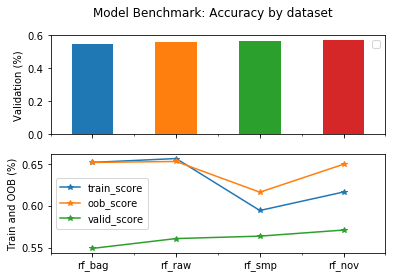

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True)
ax1, ax2 = axs

results.sort_values(by='valid_score').plot.bar(y='valid_score', ax=ax1)
ax1.set_ylabel('Validation (%)')
ax1.legend('')
results.sort_values(by='valid_score').plot(y=['train_score','oob_score', 'valid_score'], marker='*', ax=ax2)
ax2.set_ylabel('Train and OOB (%)')
plt.suptitle('Model Benchmark: Accuracy by dataset')
plt.show()

# HyperParameter Tunning

To fit final model, let's firstly screen our features set. Decision Trees in scikit-learn treat categorical variables as OHE, then populating a lot of this variables may lead to a change in recommended max_features vale (percentage of features considered at each split in a decision tree)

In addition, as non-overlap sampling is carried out, weekday variables can be dropped; quarter variables seem to be an efficient features. A proper feature screening exercise will analyze distribution, correlantion and sparsity systematically of the entire set of features.

In [17]:
features = [x for x in features if not x.startswith("weekday_") ]

In [18]:
X_train = X_train[features].copy()
X_valid = X_valid[features].copy()
X_test = X_test[features].copy()

## Grid Search

In [19]:
nov_clf_parameters = ParameterGrid({
    'min_samples_leaf': np.array([5, 10, 20])*n_stocks,
    'n_estimators': [100],
    'criterion': ['entropy'],
    'max_features': [0.5, 0.75, 1.0],
    'oob_score': [True],
    'n_jobs': [-1],
    'random_state': [clf_random_state]})

In [20]:
nov_models, nov_results = mle_utils.votrf_train_val_grid_search(nov_clf_parameters, X_train, y_train, X_valid, y_valid, 4)

Training Models: 100%|██████████| 9/9 [02:16<00:00, 15.19s/Model]


In [21]:
select_cols = ['max_features', 'min_samples_leaf', 'train_pmean', 'train_score', 'valid_pmean', 'valid_score', 'oob_score']
nov_results.sort_values(by='valid_score', ascending=False)[select_cols]

,max_features,min_samples_leaf,train_pmean,train_score,valid_pmean,valid_score,oob_score
4,0.75,5000,0.799188,0.590613,0.940208,0.576083,0.612212
7,1.00,5000,0.765816,0.590807,0.933432,0.573191,0.604441
1,0.50,5000,0.845263,0.585635,0.956636,0.568964,0.609484
8,1.00,10000,0.54392,0.565538,0.766711,0.559434,0.583801
2,0.50,10000,1,0.569254,1,0.55763,0.578519
5,0.75,10000,1,0.569254,1,0.55763,0.583262
0,0.50,2500,0.805115,0.604903,0.979482,0.553499,0.651443
3,0.75,2500,0.749623,0.61419,0.881131,0.551599,0.652839
6,1.00,2500,0.694029,0.622722,0.826476,0.540128,0.645593


## Fit final model

In [22]:
fin_nov_clf_parameters = ParameterGrid({
    'min_samples_leaf': [5000],
    'n_estimators': [100],
    'criterion': ['entropy'],
    'max_features': [0.75],
    'oob_score': [True],
    'n_jobs': [-1],
    'random_state': [clf_random_state]})

In [23]:
fin_nov_models, fin_nov_results = mle_utils.votrf_train_val_grid_search(fin_nov_clf_parameters,
                                                                        pd.concat([X_train, X_valid]),
                                                                        pd.concat([y_train, y_valid]),
                                                                        X_test, y_test, 4)

Training Models: 100%|██████████| 1/1 [00:22<00:00, 22.54s/Model]


In [24]:
fin_nov_results = fin_nov_results.rename(columns={'test_pmean': 'test_pmean',
                               'test_score': 'test_score'})
fin_nov_results

,train_pmean,train_score,valid_pmean,valid_score,oob_score,criterion,max_features,min_samples_leaf,n_estimators,n_jobs,oob_score_hp,random_state
0,0.777837,0.591476,0.986517,0.506363,0.622812,entropy,0.75,5000,100,-1,True,123


## Considerations

Taking into account that alpha factors and other regular features are quite simple, an accuracy slightly above in test set is a solid figure. There are many steps towards a better model, for example:
* Advanced encoding for categorical variables
* Advanced Hyperparameter tunning and more powerfull algorithms, like XGBoost or Neural Nets
* Add more alpha factors and features relative to finantial statements, for example

# Write Data

In [27]:
all_factors[split_col] = 'train'
all_factors.loc[X_valid.index, split_col] = 'valid'
all_factors.loc[X_test.index, split_col] = 'test'
all_factors[split_col].value_counts(normalize=True)

train    0.599157
test     0.201185
valid    0.199657
Name: split, dtype: float64

In [28]:
all_factors_cast = quant_helper.cast_zipline_multidx_to_symbol(all_factors[features])
all_factors_cast.to_csv(OUTPATH + OUTFILE1)

In [29]:
targets_df_cast = quant_helper.cast_zipline_multidx_to_symbol(targets_df[['return_5d_raw', target_col, split_col]])
targets_df_cast.to_csv(OUTPATH + OUTFILE2)

In [30]:
import pickle
nov_final = fin_nov_models[0]
with open(OUTPATH + OUTFILE3, 'wb') as file:
    pickle.dump(nov_final, file)